In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [25]:
RANDOM_SEED = 42 # фиксирую RANDOM_SEED, чтобы результаты эксперимента были вопроизводимы

In [26]:
!pip freeze > requirements.txt # фиксирую версию пакетов, чтобы результаты эксперимента были вопроизводимы

In [27]:
# подгружаю данные из соревнования
DATA_DIR = '/kaggle/input/sf-booking/'
data_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
data_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

In [28]:
# для корректной обработки признаков объединяю трейн и тест в один датасет
data_train['sample'] = 1 # помечаю, где у нас трейн
data_test['sample'] = 0 # помечаю, где у нас тест
data_test['reviewer_score'] = 0 # значения, которые должны предсказать

hotels = data_test.append(data_train, sort=False).reset_index(drop=True) # объединяю в один дс

<AxesSubplot:>

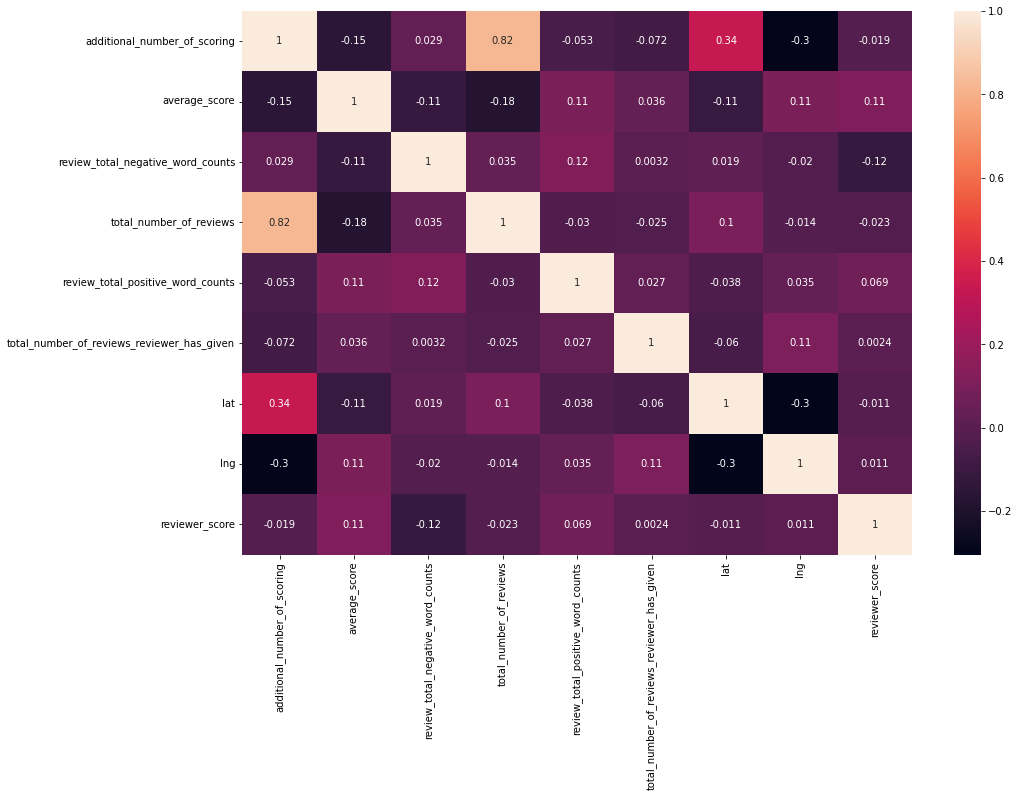

In [29]:
plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(hotels.drop(['sample'], axis=1).corr(), annot=True)

In [30]:
hotels['country'] = hotels['hotel_address'].apply(lambda x: 'United Kingdom' if x.split()[-1] == 'Kingdom' 
                                              else x.split()[-1]) # выделяю страну
hotels = pd.get_dummies(hotels, columns=['country']) # кодирую страну

In [31]:
hotels['year'] = pd.to_datetime(hotels['review_date']).dt.year # выделяю год
hotels['month'] = pd.to_datetime(hotels['review_date']).dt.month # выделяю месяц

In [32]:
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer # провожу анализ настроений
nltk.download('vader_lexicon')
sent_analyzer = SentimentIntensityAnalyzer()
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: (sent_analyzer.polarity_scores(x))['neg'])
hotels['positive_review'] = hotels['positive_review'].apply(
    lambda x: (sent_analyzer.polarity_scores(x))['pos'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [33]:
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: x.split()[0]) # убираю лишние символы

In [34]:
hotels = hotels.drop(['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 
                  'tags', 'lat', 'lng'], axis=1) # удаляю лишние признаки

In [35]:
# выделяю тестовую часть
train_data = hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values # мой таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [36]:
# воспользуюсь специальной функцией train_test_split для разбивки тестовых данных
# выделю 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [37]:
# проверяю
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 18), (386803, 18), (386803, 17), (309442, 17), (77361, 17))

In [38]:
# импортирую необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструмент для оценки точности модели

In [39]:
# создаю модель
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [40]:
# обучаю модель на тестовом наборе данных
model.fit(X_train, y_train)

# использую обученную модель для предсказания рейтинга отелей в тестовой выборке
# предсказанные значения записываю в переменную
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.6s finished


In [41]:
# сравниваю предсказанные значения (y_pred) с реальными (y_test), смотрю, насколько они в среднем отличаются
# метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

MAPE: 0.9051237749610512


<AxesSubplot:>

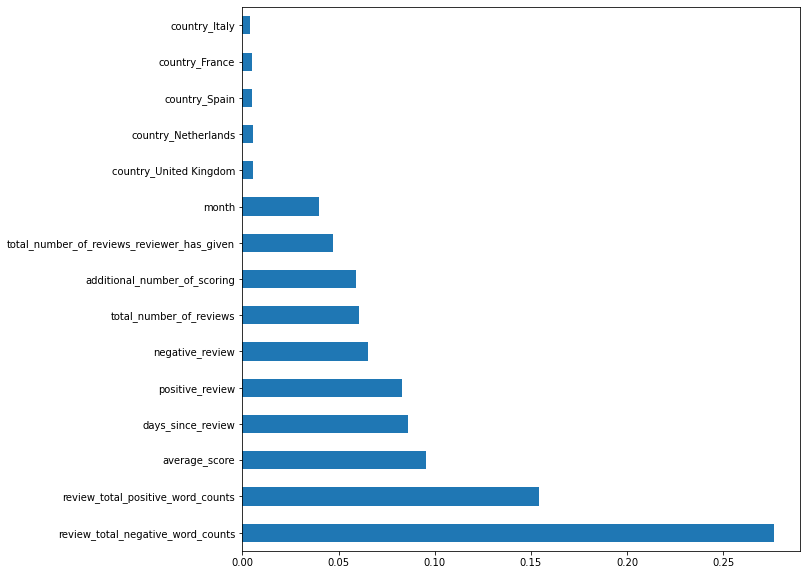

In [42]:
# вывожу самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [43]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [44]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.5s finished


In [45]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.447,488440
1,7.425,274649
2,8.589,374688
3,9.805,404352
4,9.669,451596
5,8.787,302161
6,7.781,317079
7,7.477,13963
8,8.252,159785
9,7.914,195089
